In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)

import sys
sys.path.insert(0, '../src/')

import kaczmarz
import time

In [2]:
def apply_rff(A, k, sigma=1):
    n = A.shape[1]
    A_g = A = A.dot(sigma * np.random.randn(n, k))
    A_sin = np.sin(A_g)
    A_cos = np.cos(A_g)
    A_rff = np.zeros((A.shape[0], 2 * A_cos.shape[1]))
    A_rff[:, 0:A_rff.shape[1]:2] = A_cos
    A_rff[:, 1:A_rff.shape[1]:2] = A_sin
    return A_rff / np.sqrt(k)

## Function approximtion in 2D

###  $f(x) = a^{\top}x + c + \alpha \exp(-\frac{(\|x\| - \mu)^2}{\sigma})$

In [3]:
x, y = np.meshgrid(np.random.rand(100), np.random.rand(100))
A = np.vstack((x.reshape(-1), y.reshape(-1))).T

In [4]:
a = np.ones(2)
c = 1
alpha = 0.1
mu = 0
sigma = 1
b = A @ a + c + alpha * np.exp(-(np.sqrt(np.sum(A**2, axis=1)) - mu) / sigma)
b = b[:, np.newaxis]
x_lstsq = np.linalg.lstsq(A, b, rcond=None)[0]
print(np.linalg.norm(A.dot(x_lstsq) - b) / np.linalg.norm(b))

0.2126879600368992


## Apply explicit feature map via random Fourier features

In [5]:
# The dimension after RFF is 2*d 
d = 7
A = apply_rff(A, d)
m, n = A.shape
print(A.shape, b.shape)

(10000, 14) (10000, 1)


In [6]:
x_lstsq = np.linalg.lstsq(A, b, rcond=None)[0]
print(np.linalg.norm(A.dot(x_lstsq) - b) / np.linalg.norm(b))

0.00018761858452851166


## Build preconditioners

In [7]:
preprocess_time = {
    "$\gamma = 2$": 0,
    "$\gamma = 3$": 0,
    "$\gamma = 4$": 0,
}
sketch_sizes = [i * n for i in range(2, 5)]
P = {name: [] for name in preprocess_time}

In [8]:
P = {}
for k, i in enumerate(range(2, 5)):
    print("Sketch size = {}".format(n * i))
    st = time.time()
    sketch_idx = np.sort(np.random.choice(np.arange(m), sketch_sizes[k], replace=False))
    Q, R_qr = np.linalg.qr(A[sketch_idx, :])
    P["$\gamma = {}$".format(i)] = np.linalg.inv(R_qr)
    preprocess_time["$\gamma = {}$".format(i)] = time.time() - st

Sketch size = 28
Sketch size = 42
Sketch size = 56


In [9]:
preprocess_time

{'$\\gamma = 2$': 0.002566099166870117,
 '$\\gamma = 3$': 0.0014472007751464844,
 '$\\gamma = 4$': 0.0017287731170654297}

In [10]:
max_iter = 3000000
tol = 1e-6
x0 = np.zeros(n)
max_time = 3.
log_interval = 1000

In [11]:
test_methods = {"No preconditioning": kaczmarz.UniformKaczmarz(A, b),}
_ = test_methods["No preconditioning"].solve(x0, max_iter, max_time, log_interval)

In [12]:
for name in preprocess_time:
    test_methods[name] = kaczmarz.UniformKaczmarz(A, b, P_right=P[name],
                                                 preprocess_time=preprocess_time[name])

In [13]:
for name in preprocess_time:
    print(name)
    x = test_methods[name].solve(x0, max_iter, max_time, log_interval)
    print(np.linalg.norm(A @ (test_methods[name]._P_right @ x) - b) / np.linalg.norm(b))

$\gamma = 2$
0.0002581843658027876
$\gamma = 3$
0.0002496885011372268
$\gamma = 4$
0.00026495124477127164


## Prepare data for plotting

In [14]:
iter_range = {}
for i, name in enumerate(test_methods):
    iter_range[name] = [j * log_interval for j in range(len(test_methods[name].get_convergence()))]

In [15]:
y_range = {}
for i, name in enumerate(test_methods):
    print(name)
    PR = test_methods[name]._P_right
    start_prec = test_methods[name]._start_prec
#     print(len(x))
    cur_y = []
    if PR is not None:
        for j, x in enumerate(test_methods[name].get_convergence()):
            if j > start_prec:
                cur_y.append(np.linalg.norm(A.dot(PR.dot(x)) - b) / np.linalg.norm(b))
            else:
                cur_y.append(np.linalg.norm(A.dot(x) - b) / np.linalg.norm(b))
        y_range[name] = cur_y
    else:
        y_range[name] = [np.linalg.norm(A.dot(x) - b) / np.linalg.norm(b) 
                  for j, x in enumerate(test_methods[name].get_convergence())]

No preconditioning
$\gamma = 2$
$\gamma = 3$
$\gamma = 4$


In [16]:
time_range = {}
for i, name in enumerate(test_methods):
    time_range[name] = [test_methods[name].get_time()[0]] + [t for j, t in enumerate(test_methods[name].get_time()) if (j+1) % log_interval == 0] + [test_methods[name].get_time()[-1]]

## Relative error vs. number of iterations

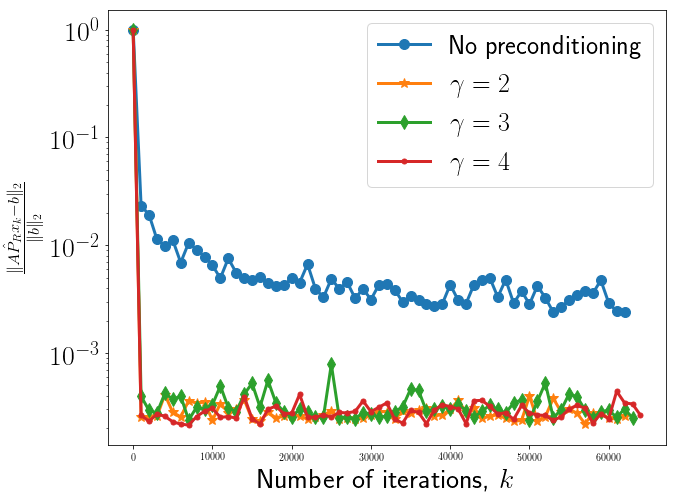

In [17]:
plt.figure(figsize=(10, 8))
markers = ["o", "*", "d", "."]

for i, name in enumerate(test_methods):
    plt.semilogy(iter_range[name], y_range[name],
                 label=name, linewidth=3, marker=markers[i % 4], markersize=10)
plt.ylabel(r"$\frac{\|A\hat{P}_Rx_k - b\|_2}{\|b\|_2}$", fontsize=24)
plt.xlabel(r"Number of iterations, $k$", fontsize=28)
plt.legend(fontsize=26)
_ = plt.yticks(fontsize=28)

## Relative error vs running time + time to construct preconditioners

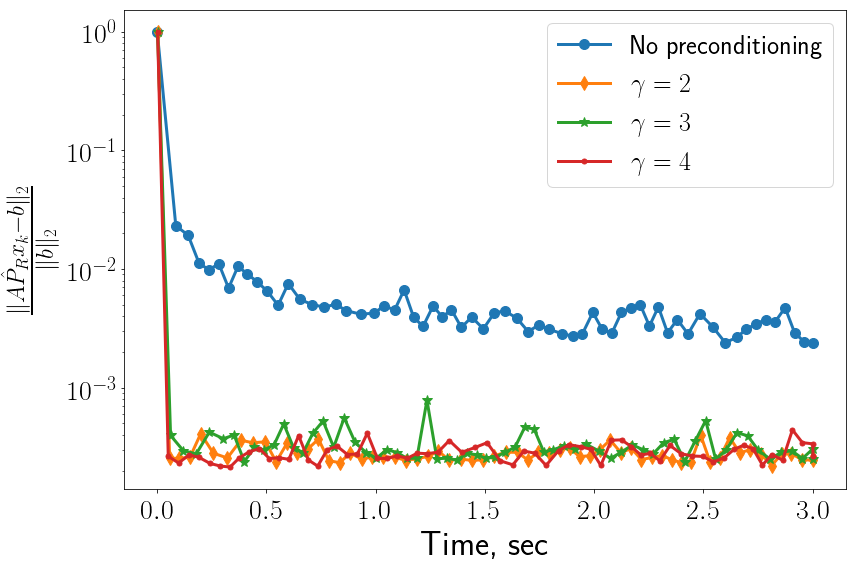

In [18]:
plt.figure(figsize=(12, 8))
markers = ["o", "*", "d", "."]
plt.semilogy(time_range["No preconditioning"], y_range["No preconditioning"],
             label="No preconditioning", linewidth=3, marker=markers[0], markersize=10)
    

plt.semilogy(time_range["$\gamma = 2$"], y_range["$\gamma = 2$"],
             label="$\gamma = 2$", linewidth=3, marker=markers[2], markersize=10)
plt.semilogy(time_range["$\gamma = 3$"], y_range["$\gamma = 3$"],
             label="$\gamma = 3$", linewidth=3, marker=markers[1], markersize=10)
plt.semilogy(time_range["$\gamma = 4$"], y_range["$\gamma = 4$"],
             label="$\gamma = 4$", linewidth=3, marker=markers[3], markersize=10)
plt.ylabel(r"$\frac{\|A\hat{P}_Rx_k - b\|_2}{\|b\|_2}$", fontsize=34)
plt.xlabel(r"Time, sec", fontsize=34)
plt.legend(fontsize=26)
_ = plt.yticks(fontsize=28)
_ = plt.xticks(fontsize=28)
plt.tight_layout()